In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import corner

from cmcrameri import cm
from matplotlib.colors import to_hex
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

from pqcd.utils import (
    to_nucleons_per_cubic_femtometre,
    nsat
)

from plot_utils import rcparams
plt.rcParams.update(rcparams)

In [2]:
# Load the collated EOSs
collated_eos_with_ntov = pd.read_csv(
    '../data/eos-draws-default/collated_np_all_post.csv',
    index_col='eos'
)
collated_eos = pd.read_csv(
    '../data/eos-draws-default/eos-draws-default.csv',
    index_col='eos'
)
collated_eos_nonzero_astro = pd.read_csv(
    '../data/eos-draws-default/eos-draws-default-nonzero-astro.csv',
    index_col='eos'
)

In [3]:
collated_eos['ntov'] = collated_eos_with_ntov['rhoc(M@Mmax)']
collated_eos['R14'] = collated_eos_with_ntov['R(M=1.4)']

In [4]:
ntov_weights = [
    np.loadtxt('../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_Xmarg_mu2.6.dat'),
    np.loadtxt('../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_marg.dat')
]

In [5]:
mask = collated_eos['R14'] > 5

In [6]:
nterm_list = [4,5,6,7,8]

c_dict = {
    nterm: cm.berlin(i/(len(nterm_list)-1)) for i, nterm in enumerate(nterm_list)
}

linestyles = 2*['-', '--', '-.', ':']
ls_dict = {
    nterm: linestyles[i] for i, nterm in enumerate(nterm_list)
}

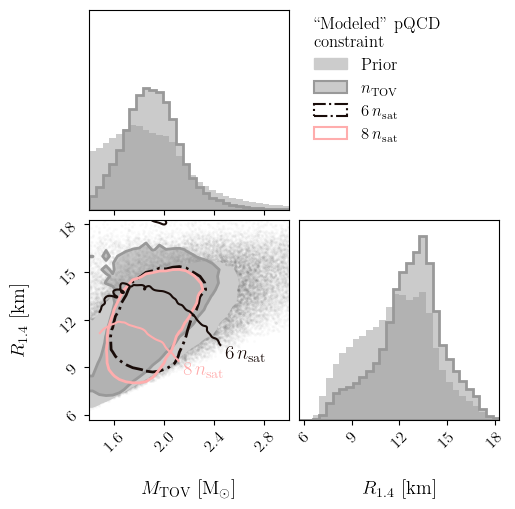

In [7]:
plot_range = [[1.4, 3], [5.7, 18.3]]

# Prior
# -----

fig = corner.corner(
    collated_eos[['Mmax', 'R14']][mask], 
    labels=[r'$M_{\rm TOV}$ [M$_\odot$]', r'$R_{1.4}$ [km]'],
    bins=30, 
    levels=[0.9],
    range=plot_range,
    smooth=0.5,
    color='k',
    plot_datapoints=True,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=True,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'colors': '#cccccc', 'antialiased': True},
    hist_kwargs={'density': True, 'histtype': 'stepfilled', 'color': '#cccccc'}
)

# nTOV
# ----

corner.corner(
    collated_eos[['Mmax', 'R14']][mask], 
    weights=ntov_weights[1][mask],
    fig=fig,
    bins=30, 
    levels=[0.9],
    range=plot_range,
    smooth=0.5,
    color='#999999', 
    plot_datapoints=False,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=True,
    contour_kwargs={'linewidths': 2},
    contourf_kwargs={'colors': '#999999', 'antialiased': True, 'alpha': 0.5},
    hist_kwargs={
        'density': True, 
        'histtype': 'stepfilled', 
        'edgecolor': '#999999', 
        'linewidth': 2, 
        'facecolor': [0.6, 0.6, 0.6, 0.5]
    }
)

# nterm
# -----

for i, nterm in enumerate([6,8]):
    
    weights = np.loadtxt(
        f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{nterm:02}nsat_marg.dat'
    )

    color = c_dict[nterm]
    linestyle = ls_dict[nterm]

    corner.corner(
        collated_eos[['Mmax', 'R14']][mask], 
        weights=weights[mask],
        fig=fig,
        bins=30, 
        levels=[0.9],
        range=plot_range,
        smooth=0.5,
        color=to_hex(color),
        plot_datapoints=False,
        fill_contours=False,
        plot_density=False,
        no_fill_contours=True,
        contour_kwargs={'linewidths': 2, 'linestyles': linestyle},
        hist_kwargs={
            'density': True, 
            'histtype': 'step', 
            'color': to_hex(color), 
            'linewidth': 0, 
        }
    )

# ---

# Contours

n_grid = 1000
grid_x, grid_y = np.mgrid[
    plot_range[0][0]:plot_range[0][1]:n_grid*1j, 
    plot_range[1][0]:plot_range[1][1]:n_grid*1j
]

points = collated_eos[['Mmax', 'R14']][mask].values
values = to_nucleons_per_cubic_femtometre(collated_eos['ntov'][mask].values)/nsat
grid = griddata(points, values, (grid_x, grid_y), method='linear')
grid = gaussian_filter(grid, 12)

axs = fig.axes

CS = axs[2].contour(
    grid_x, 
    grid_y, 
    grid, 
    [6,8], 
    linestyles='-', 
    linewidths=1.5, 
    alpha=1, 
    colors=[c_dict[6], c_dict[8]]
)

for i, nterm in enumerate([6,8]):
    axs[2].text(
        CS.allsegs[i][0][-1][0]+0.03, 
        CS.allsegs[i][0][-1][1]-0.03, 
        f'${nterm}\,n_\mathrm{{sat}}$', 
        color=c_dict[nterm], 
        fontsize=14, 
        horizontalalignment='left', 
        verticalalignment='top'
    )

# ---

handles = [
    mpatches.Patch(color='#cccccc', label='Prior'),
    mpatches.Patch(
        edgecolor= '#999999', 
        linewidth= 1.5, 
        facecolor=[0.6, 0.6, 0.6, 0.5], 
        label='$n_\mathrm{TOV}$'
    )
]

for nterm in [6,8]:
    handles.append(
        mpatches.Patch(
            edgecolor=c_dict[nterm], 
            linewidth=1.5, 
            facecolor=[0.6, 0.6, 0.6, 0.0], 
            linestyle=ls_dict[nterm], 
            label=f'${nterm}\,n_\mathrm{{sat}}$'
        )
    )

l = fig.legend(
    handles=handles, 
    loc='upper right', 
    bbox_to_anchor=(0.85, 0.94),
    frameon=False,
    title='``Modeled" pQCD\nconstraint',
    title_fontsize=12
)

l._legend_box.align = "left"

fig.savefig('figures/paper/pqcd_marg_m_r_14_corner.pdf', bbox_inches='tight')

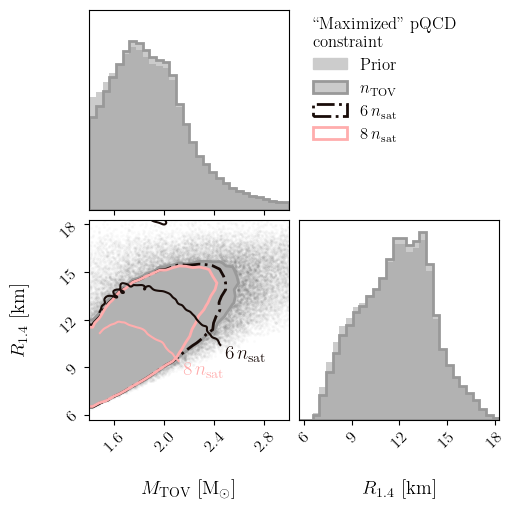

In [8]:
plot_range = [[1.4, 3], [5.7, 18.3]]

# Prior
# -----

fig = corner.corner(
    collated_eos[['Mmax', 'R14']][mask], 
    labels=[r'$M_{\rm TOV}$ [M$_\odot$]', r'$R_{1.4}$ [km]'],
    bins=30, 
    levels=[0.9],
    range=plot_range,
    smooth=0.5,
    color='k',
    plot_datapoints=True,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=True,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'colors': '#cccccc', 'antialiased': True},
    hist_kwargs={'density': True, 'histtype': 'stepfilled', 'color': '#cccccc'}
)

# nTOV
# ----

corner.corner(
    collated_eos[['Mmax', 'R14']][mask], 
    weights=ntov_weights[0][mask],
    fig=fig,
    bins=30, 
    levels=[0.9],
    range=plot_range,
    smooth=0.5,
    color='#999999', 
    plot_datapoints=False,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=True,
    contour_kwargs={'linewidths': 2},
    contourf_kwargs={'colors': '#999999', 'antialiased': True, 'alpha': 0.5},
    hist_kwargs={
        'density': True, 
        'histtype': 'stepfilled', 
        'edgecolor': '#999999', 
        'linewidth': 2, 
        'facecolor': [0.6, 0.6, 0.6, 0.5]
    }
)

# nterm
# -----

for i, nterm in enumerate([6,8]):
    
    weights = np.loadtxt(
        f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{nterm:02}nsat_Xmarg_mu2.6.dat'
    )

    color = c_dict[nterm]
    linestyle = ls_dict[nterm]

    corner.corner(
        collated_eos[['Mmax', 'R14']][mask], 
        weights=weights[mask],
        fig=fig,
        bins=30, 
        levels=[0.9],
        range=plot_range,
        smooth=0.5,
        color=to_hex(color),
        plot_datapoints=False,
        fill_contours=False,
        plot_density=False,
        no_fill_contours=True,
        contour_kwargs={'linewidths': 2, 'linestyles': linestyle},
        hist_kwargs={
            'density': True, 
            'histtype': 'step', 
            'color': to_hex(color), 
            'linewidth': 0, 
        }
    );

# ---

n_grid = 1000
grid_x, grid_y = np.mgrid[
    plot_range[0][0]:plot_range[0][1]:n_grid*1j, 
    plot_range[1][0]:plot_range[1][1]:n_grid*1j
]

points = collated_eos[['Mmax', 'R14']][mask].values
values = to_nucleons_per_cubic_femtometre(collated_eos['ntov'][mask].values)/nsat
grid = griddata(points, values, (grid_x, grid_y), method='linear')
grid = gaussian_filter(grid, 12)

axs = fig.axes

CS = axs[2].contour(
    grid_x, 
    grid_y, 
    grid, 
    [6,8], 
    linestyles='-', 
    linewidths=1.5, 
    alpha=1, 
    colors=[c_dict[6], c_dict[8]]
)

for i, nterm in enumerate([6,8]):
    axs[2].text(
        CS.allsegs[i][0][-1][0]+0.03, 
        CS.allsegs[i][0][-1][1]-0.03, 
        f'${nterm}\,n_\mathrm{{sat}}$', 
        color=c_dict[nterm], 
        fontsize=14, 
        horizontalalignment='left', 
        verticalalignment='top'
    )

# ---

handles = [
    mpatches.Patch(color='#cccccc', label='Prior'),
    mpatches.Patch(
        edgecolor='#999999', 
        linewidth=2, 
        facecolor=[0.6, 0.6, 0.6, 0.5], 
        label='$n_\mathrm{TOV}$'
    )
]

for nterm in [6,8]:
    handles.append(
        mpatches.Patch(
            edgecolor=c_dict[nterm], 
            linewidth=2, 
            facecolor=[0.6, 0.6, 0.6, 0.0], 
            linestyle=ls_dict[nterm], 
            label=f'${nterm}\,n_\mathrm{{sat}}$'
        )
    )

l = fig.legend(
    handles=handles, 
    loc='upper right', 
    bbox_to_anchor=(0.88, 0.94),
    frameon=False,
    title='``Maximized" pQCD\nconstraint',
    title_fontsize=12
)

l._legend_box.align = "left"

fig.savefig('figures/paper/pqcd_Xmarg_m_r_14_corner.pdf', bbox_inches='tight')